This notebook reads in some Sea Level Pressure data for the North Atlantic region. It then creates the "NAO index", which (here) is defined as the difference in pressure between Lisbon and Iceland. It then uses that as the target for a neural network (but not necessarily convolutional?). It currently approaches this as a classification problem (High NAO, Middle NAO, Low NAO). After having created a neural net, I'd like to be able to interrogate it, and see what particular features it finds are the most important. In this scenario, I know what the truth is as I have used the NAO index as the target, which is defined using the input data: So the important features are high pressure over Lisbon and low pressure over Iceland. But I would like to be able to "see" that the network is indeed looking for those.

How do I do that?..

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [3]:
# import netCDF4
import numpy as np
import glob
import scipy.stats as stats
import pickle
import socket
import os
import time

import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec

%matplotlib inline

# basedir = '/home/mmenary/python/notebooks/MachineLearning/output/'
# data_file = '/data/mmenary/IPSL_temp/psl_ann_natl_1850_3049.nc'
# data_file_out = 'psl_ann_natl_1850_3049.npz'
pickle_file = 'psl_ann_natl_1850_3049.pkl'

In [6]:
if os.path.exists(pickle_file):
    print("Loading pickle file")
    with open(pickle_file, 'rb') as handle:
        psl, lon, lat = pickle.load(handle, encoding='latin1')
elif socket.gethostname() == 'ciclad-ng.private.ipsl.fr':
    print("Creating pickle file")
    loaded = netCDF4.Dataset(data_file)
    psl = loaded.variables['psl'][:] / 100.  # Divide by 100 to convert units from Pa to hPa
    lon = loaded.variables['lon'][:]
    lat = loaded.variables['lat'][:]
    
    # We don't care about the order so shuffle in case there is a trend through time
    np.random.shuffle(psl)
    
    with open(pickle_file, 'wb') as handle:
        pickle.dump([psl, lon, lat], handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    raise ValueError("Download the data from here: https://drive.google.com/file/d/163eJ8kTbjPxtNkk_G8FQb_8na_2QlPHw/view?usp=sharing")

Loading pickle file


In [7]:
# loaded = netCDF4.Dataset(data_file)
# psl = loaded.variables['psl'][:] / 100.  # Divide by 100 to convert units from Pa to hPa
# lon = loaded.variables['lon'][:]
# lat = loaded.variables['lat'][:]

# # We don't care about the order so shuffle in case there is a trend through time
# np.random.shuffle(psl)

# np.savez(data_file_out, psl=psl.data, lon=lon.data, lat=lat.data)

In [9]:
nt, nj, ni = psl.shape
print(nt, nj, ni)

1200 72 65


In [10]:
# Make the NAO (North Atlantic Oscillation) index
j1, i1 = 102-71, 140-104  # Lisbon
j0, i0 = 121-71, 135-104  # Iceland
nao = psl[:, j1, i1] - psl[:, j0, i0]
# np.savetxt("nao_index.csv", nao, delimiter=",")

In [33]:
# Regress the global PSL on to this
psl_nao_grad = np.ma.masked_all(shape=(nj, ni))
psl_nao_corr = np.ma.masked_all(shape=(nj, ni))

for jj in range(nj):
    for ii in range(ni):
        grad, _, corr, _, _, = stats.linregress(nao, psl[:, jj, ii])
        psl_nao_grad[jj, ii] = grad
        psl_nao_corr[jj, ii] = corr  

print(psl_nao_grad.shape)
print(psl_nao_grad)

(72, 65)
[[0.020568016305244838 0.02039764233358281 0.019996473541214848 ...
  -0.004359394219217054 -0.003980735030602871 -0.003561295308610988]
 [0.021037148272560244 0.02087802701108322 0.02054170609218271 ...
  -0.004404327021357291 -0.0038908416942898647 -0.00347438752683709]
 [0.021898674012158243 0.02178650209148278 0.02137999054558355 ...
  -0.00460658345075326 -0.004008506933749933 -0.003462762491169888]
 ...
 [-0.4037089534577301 -0.4046651905621519 -0.40563816292841726 ...
  -0.392913889628369 -0.3917734753591054 -0.39067555478967403]
 [-0.40181600371503434 -0.40227888271770323 -0.40277307898472914 ...
  -0.3961805497597348 -0.3956094746494077 -0.3950120344242564]
 [-0.39709000330978406 -0.39709000330978406 -0.39709000330978406 ...
  -0.39709000330978406 -0.39709000330978406 -0.39709000330978406]]


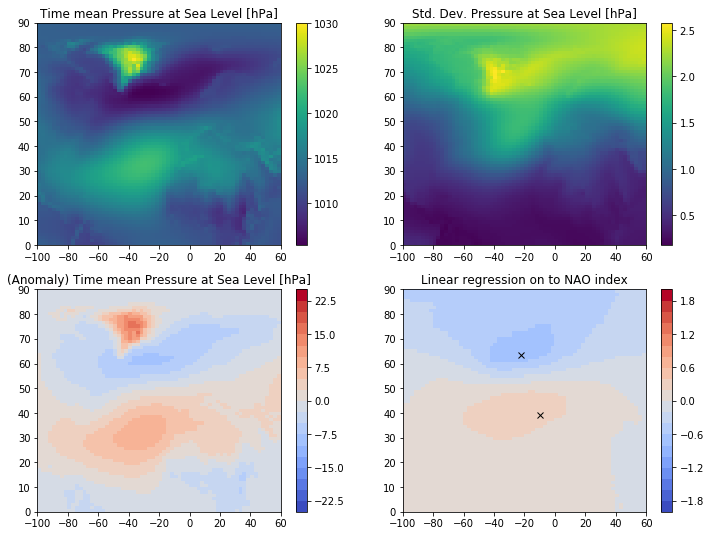

In [12]:
cmap = plt.get_cmap('coolwarm')
levels_anom = np.linspace(-25, 25, 21)
norm_anom = BoundaryNorm(levels_anom, ncolors=cmap.N, clip=True)
norm_anom2 = BoundaryNorm(levels_anom/2., ncolors=cmap.N, clip=True)
levels_grad = np.linspace(-2, 2, 21)
norm_grad = BoundaryNorm(levels_grad, ncolors=cmap.N, clip=True)

plt.figure(figsize=(12, 9))

plt.subplot(2, 2, 1)
plt.pcolormesh(lon, lat, psl.mean(axis=0), rasterized=True)
plt.colorbar()
plt.title('Time mean Pressure at Sea Level [hPa]')

plt.subplot(2, 2, 2)
plt.pcolormesh(lon, lat, psl.std(axis=0), rasterized=True)
plt.colorbar()
plt.title('Std. Dev. Pressure at Sea Level [hPa]')

plt.subplot(2, 2, 3)
plt.pcolormesh(lon, lat, (psl.mean(axis=0) - psl.mean()), cmap=cmap, norm=norm_anom, rasterized=True)
plt.colorbar()
plt.title('(Anomaly) Time mean Pressure at Sea Level [hPa]')

plt.subplot(2, 2, 4)
plt.pcolormesh(lon, lat, psl_nao_grad, cmap=cmap, norm=norm_grad, rasterized=True)
plt.plot(lon[i0], lat[j0], 'x', color='k')
plt.plot(lon[i1], lat[j1], 'x', color='k')
plt.colorbar()
plt.title('Linear regression on to NAO index')

plt.show()

In [13]:
# Attempt to implement Craig's classification chat

In [15]:
nt2 = (3 * nt) // 4  # Take 3/4 of the data for training, keep 1/4 for testing
t0, t1 = np.sort(nao[:nt2])[[nt2//3, (2*nt2)//3]]  # Find the tercile boundaries
class_names = ['--NAO', 'nothing', '++NAO']
class_labels = [0, 1, 2]

train_names = np.array(['nothing'] * nt2)
train_labels = np.ones(nt2, dtype='uint8')
train_names[np.nonzero(np.less(nao[:nt2], t0))[0]] = '--NAO'
train_labels[np.nonzero(np.less(nao[:nt2], t0))[0]] = 0
train_names[np.nonzero(np.greater(nao[:nt2], t1))[0]] = '++NAO'
train_labels[np.nonzero(np.greater(nao[:nt2], t1))[0]] = 2

test_names = np.array(['nothing'] * (nt - nt2))
test_labels = np.ones(nt - nt2, dtype='uint8')
test_names[np.nonzero(np.less(nao[nt2:], t0))[0]] = '--NAO'
test_labels[np.nonzero(np.less(nao[nt2:], t0))[0]] = 0
test_names[np.nonzero(np.greater(nao[nt2:], t1))[0]] = '++NAO'
test_labels[np.nonzero(np.greater(nao[nt2:], t1))[0]] = 2

print(train_labels, nt, nt2)

[0 0 2 1 0 2 1 0 2 0 2 2 2 1 1 0 0 0 2 1 0 0 2 0 0 2 2 0 1 2 2 1 2 2 0 1 0
 1 2 0 2 2 1 2 1 0 0 1 0 2 0 1 2 1 2 0 2 1 1 0 1 2 0 1 0 2 2 2 2 2 0 1 1 1
 0 1 0 0 1 0 2 1 1 2 2 1 1 2 2 0 2 0 2 1 0 1 0 0 2 2 0 0 2 0 1 2 1 1 1 0 2
 0 2 1 2 0 2 1 0 1 2 0 1 2 2 2 1 0 2 0 0 2 2 2 0 1 0 1 2 1 1 1 2 2 0 2 2 1
 2 0 0 0 2 2 0 1 0 0 0 2 1 2 0 0 1 2 0 0 1 2 1 0 2 2 2 0 1 1 1 1 0 1 0 1 0
 1 2 1 1 2 2 2 1 2 0 1 1 2 2 2 2 2 2 1 0 0 0 0 0 0 0 0 1 2 0 1 0 1 2 0 0 0
 1 0 0 2 0 2 1 2 0 1 0 1 1 2 2 2 1 1 1 1 1 0 2 0 1 1 2 2 1 1 2 1 2 2 2 1 2
 2 2 2 0 1 0 1 2 1 2 0 0 2 2 2 0 2 1 0 1 1 2 1 0 1 0 2 2 2 1 1 2 1 1 0 2 0
 0 0 0 1 0 0 2 1 2 2 1 2 0 0 1 1 2 0 2 1 2 2 1 0 1 1 1 1 0 2 2 2 1 1 1 2 2
 1 1 1 0 1 1 0 0 0 1 2 2 2 2 0 1 1 0 1 1 0 2 2 1 1 0 2 1 0 2 1 1 0 1 2 1 1
 2 0 1 2 2 2 1 1 2 1 0 2 0 0 2 2 0 0 0 1 0 0 0 0 1 2 1 0 2 2 2 1 1 2 0 0 0
 0 1 1 1 2 0 1 1 0 0 2 0 2 1 0 1 1 1 2 1 0 0 0 1 1 0 0 1 0 2 2 0 1 2 1 0 1
 0 0 2 2 2 1 0 2 1 0 1 2 1 1 0 1 1 0 0 2 1 2 1 2 0 0 0 0 2 2 2 0 2 1 0 2 2
 2 2 1 2 2 0 2 1 1 2 0 1 

In [17]:
# Put the PSL into the range [0, 1]
train_images = (psl[:nt2, :, :] - psl[:nt2, :, :].min()) / np.ptp(psl[:nt2, :, :])
train_psl = psl[:nt2, :, :] - np.repeat(psl[:nt2, :, :].mean(axis=0)[np.newaxis, :, :], nt2, axis=0)
test_images = (psl[nt2:, :, :] - psl[nt2:, :, :].min()) / np.ptp(psl[nt2:, :, :])
test_psl = psl[nt2:, :, :] - np.repeat(psl[nt2:, :, :].mean(axis=0)[np.newaxis, :, :], nt-nt2, axis=0)
print(train_images.min(), train_images.max())

0.0 1.0


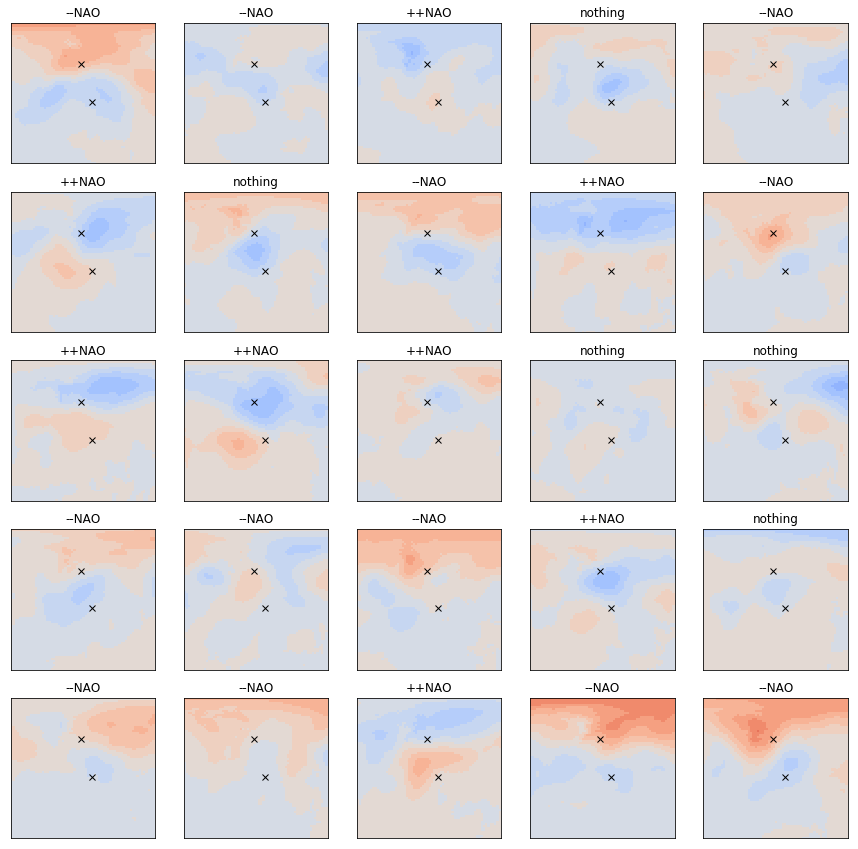

In [18]:
cmap = plt.get_cmap('coolwarm')
levels = np.linspace(-1, 2, 21)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

plt.figure(figsize=(15, 15))
for ii in range(25):
    plt.subplot(5, 5, ii+1)
#     plt.pcolormesh(lon, lat, train_images[ii, :, :], cmap=cmap, norm=norm)
    plt.pcolormesh(lon, lat, train_psl[ii, :, :], cmap=cmap, norm=norm_anom2)
    plt.plot(lon[i0], lat[j0], 'x', color='k')
    plt.plot(lon[i1], lat[j1], 'x', color='k')
    plt.title(train_names[ii])
    plt.xticks([])
    plt.yticks([])

In [19]:
# # 1) Model taken from the internet for simple image characterisation
# cnn = Sequential()
# cnn.add(Flatten(input_shape=(nj, ni)))
# cnn.add(Dense(128))
# cnn.add(Activation('relu'))
# cnn.add(Dense(10))
# cnn.add(Activation('softmax'))
# cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
# 2) As above but I changed some parameters
cnn = Sequential()
cnn.add(Flatten(input_shape=(nj, ni)))
# cnn.add(Conv2D(32, (3, 3), input_shape=(nj, ni, 1)))
cnn.add(Dense(512))
cnn.add(Activation('relu'))
cnn.add(Dense(64))
cnn.add(Activation('relu'))
cnn.add(Dense(3))
cnn.add(Activation('softmax'))
cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [21]:
# # 3) CNN with convolutional bits
cnn = Sequential()

cnn.add(Conv2D(32, (3, 3), input_shape=(nj, ni, 1)))
cnn.add(BatchNormalization(axis=-1))
cnn.add(Activation('relu'))
cnn.add(Conv2D(32, (3, 3)))
cnn.add(BatchNormalization(axis=-1))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.3))  # Added this

cnn.add(Conv2D(64, (3, 3)))
cnn.add(BatchNormalization(axis=-1))
cnn.add(Activation('relu'))
cnn.add(Conv2D(64, (3, 3)))
cnn.add(BatchNormalization(axis=-1))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.3))  # Added this

cnn.add(Flatten())

# Fully connected layer
cnn.add(Dense(512))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(Dropout(0.3))
cnn.add(Dense(3))

cnn.add(Activation('softmax'))

cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
# Fit the model
time0 = time.time()

# cnn.fit(train_images, train_labels, epochs=40)  # If not using Convolution
cnn.fit(train_images.reshape([nt2, nj, ni, 1]), train_labels, epochs=10)  # If using convolution

print("Time taken: {:.1f} minutes".format((time.time() - time0) / 60.))

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
900/900 [==============================] - 27s 30ms/step - loss: 0.6410 - accuracy: 0.7444
Epoch 2/10
900/900 [==============================] - 27s 30ms/step - loss: 0.5188 - accuracy: 0.7933
Epoch 3/10
900/900 [==============================] - 27s 30ms/step - loss: 0.3539 - accuracy: 0.8544
Epoch 4/10
900/900 [==============================] - 27s 30ms/step - loss: 0.3839 - accuracy: 0.8456
Epoch 5/10
900/900 [==============================] - 27s 30ms/step - loss: 0.3186 - accuracy: 0.8567
Epoch 6/10
900/900 [==============================] - 27s 30ms/step - loss: 0.3190 - accuracy: 0.8600
Epoch 7/10
900/900 [==============================] - 26s 29ms/step - loss: 0.3553 - accuracy: 0.8344
Epoch 8/10
900/900 [==============================] - 26s 29ms/step - loss: 0.2580 - accuracy: 0.8900
Epoch 9/10
900/900 [==============================] - 28s 31ms/step - loss: 0.3046 - accuracy: 0.8656
Epoch 10/10
900/900 [=============

In [25]:
# Test the model on unseen data
time0 = time.time()

# test_loss, test_acc = cnn.evaluate(test_images, test_labels)
test_loss, test_acc = cnn.evaluate(test_images.reshape([nt-nt2, nj, ni, 1]), test_labels)

print('Test accuracy:', test_acc)
print("Time taken: {:.1f} minutes".format((time.time() - time0) / 60.))

300/300 [==============================] - 2s 7ms/step
Test accuracy: 0.3100000023841858
Time taken: 0.0 minutes


In [26]:
# Predictions
time0 = time.time()

# predictions = cnn.predict(test_images)
predictions = cnn.predict(test_images.reshape([nt-nt2, nj, ni, 1]))

print("Time taken: {:.1f} minutes".format((time.time() - time0) / 60.))
print(predictions.shape)

Time taken: 0.0 minutes
(300, 3)


In [27]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.pcolormesh(lon, lat, img, cmap=cmap, norm=norm_anom2)
    plt.plot(lon[i0], lat[j0], 'x', color='k')
    plt.plot(lon[i1], lat[j1], 'x', color='k')

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.title("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
#     print i, predictions_array.shape, predictions_array
    thisplot = plt.bar(range(3), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

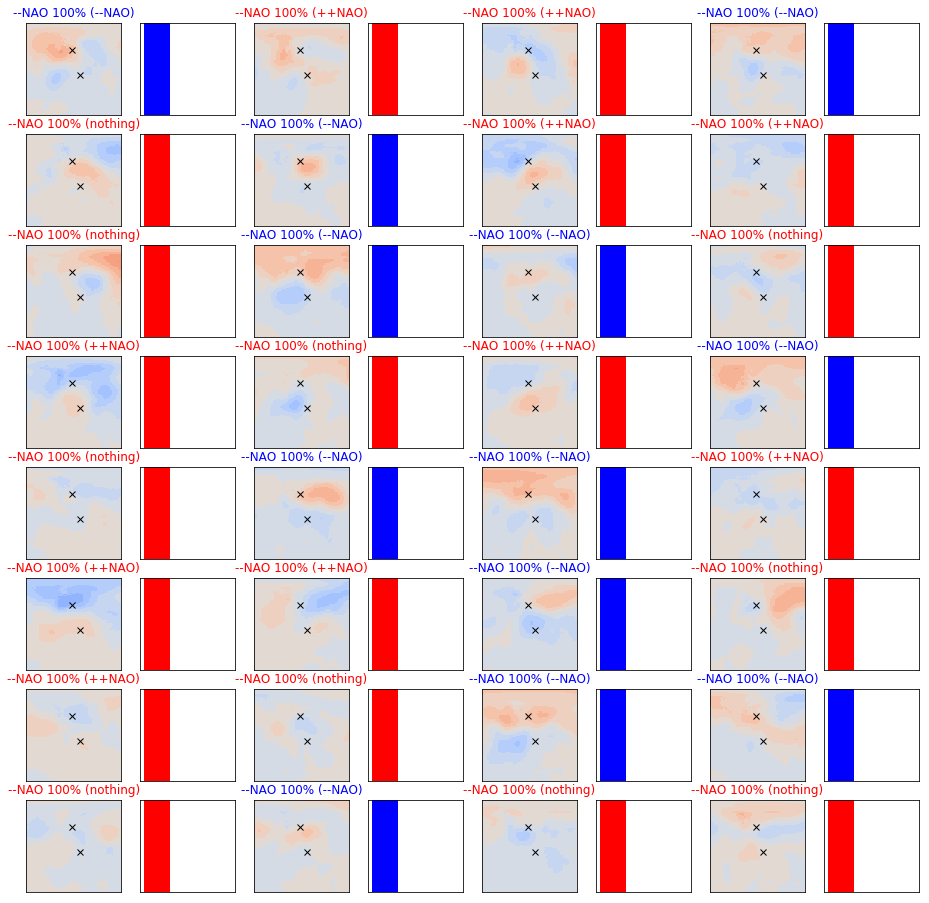

In [28]:
# Plot the first X test images, their predicted label, and the true label in brackets
# Color correct predictions in blue, incorrect predictions in red
num_rows = 8
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, test_labels, test_psl)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_labels)
plt.show()

In [30]:
print(cnn.layers)

[<keras.layers.convolutional.Conv2D object at 0x1385310f0>, <keras.layers.normalization.BatchNormalization object at 0x138531160>, <keras.layers.core.Activation object at 0x138531390>, <keras.layers.convolutional.Conv2D object at 0x12ba16390>, <keras.layers.normalization.BatchNormalization object at 0x138543e80>, <keras.layers.core.Activation object at 0x12ba12a58>, <keras.layers.pooling.MaxPooling2D object at 0x105795dd8>, <keras.layers.core.Dropout object at 0x1382d8828>, <keras.layers.convolutional.Conv2D object at 0x1385313c8>, <keras.layers.normalization.BatchNormalization object at 0x105184978>, <keras.layers.core.Activation object at 0x1057c7940>, <keras.layers.convolutional.Conv2D object at 0x1057c7cf8>, <keras.layers.normalization.BatchNormalization object at 0x106cc7908>, <keras.layers.core.Activation object at 0x106d19ef0>, <keras.layers.pooling.MaxPooling2D object at 0x106d12080>, <keras.layers.core.Dropout object at 0x106e9a7b8>, <keras.layers.core.Flatten object at 0x106e

(300, 3) (300, 3)
--NAO     No. of test patterns with confidence > 0.95 : 100
nothing   No. of test patterns with confidence > 0.95 : 0
++NAO     No. of test patterns with confidence > 0.95 : 0


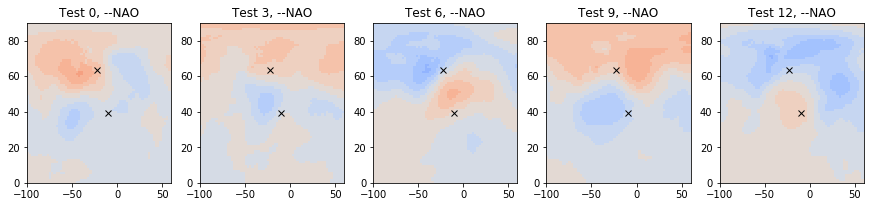

In [31]:
predicted_label = np.repeat(np.argmax(predictions, axis=1)[:, np.newaxis], 3, axis=1)

print(predictions.shape, predicted_label.shape)

min_conf = 0.95

plt.figure(figsize=(15, 10))
for ilabel, label in enumerate(class_labels):
    most_confident_guesses = np.argwhere((predicted_label == label) & (predictions > min_conf))[::3][:, 0]
    print('{:8s}  No. of test patterns with confidence > {:.2f} : {:d}'.format(class_names[ilabel], min_conf, len(most_confident_guesses)))
    if len(most_confident_guesses) > 0:
        max_plots = np.min([len(most_confident_guesses), 5])
        for ii in range(max_plots):
            plt.subplot(3, 5, ilabel*5+ii+1)
            plt.pcolormesh(lon, lat, test_psl[most_confident_guesses[ii], :, :], cmap=cmap, norm=norm_anom2)
            plt.title('Test {:d}, {:s}'.format(most_confident_guesses[ii], class_names[ilabel]))
            plt.plot(lon[i0], lat[j0], 'x', color='k')
            plt.plot(lon[i1], lat[j1], 'x', color='k')

Perhaps looking at the FAILURES would be helpful? If the NN said No-NAO and the linear regression said there was - well the linear regression is the DEFINITION so it is right...

CNNs let the final image (e.g. cat face) be anywhere in the domain - for meteorology that would be silly. We don't want to end up with a Model that sees an SST gradient in the South Pacific, and tries to use that to explain HWs in Europe. Is there a way of putting the location information in?